In [1]:
import math

def processed(img):
    grayscale=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    smoothen=cv2.GaussianBlur(grayscale, (5,5), 0)
    return cv2.Canny(smoothen, 180, 240)

In [2]:
def roi(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [3]:
def display_lane(img, lines, color=[255, 102, 0], thickness=10):
    for line in lines:
        #print(line)
        x1, y1, x2, y2 = line.reshape(4)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)  

In [4]:
def average_slope_lines(image,lines):
    
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] 
    right_lines = [] 
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass 
            else:
                slope = (y2 - y1) / (x2 - x1)
                intercept = y1 - slope * x1

                if slope < 0:
                    left_lines.append((slope,intercept))
                elif slope >= 0:
                    right_lines.append((slope,intercept))

    left_average = np.mean(left_lines, axis=0)
    right_average = np.mean(right_lines, axis=0)
    poly_vertices=[]
    
    try:
        slope, intercept = left_average
    except TypeError:
        slope, intercept = 0.001, 0
    #slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    poly_vertices.append((x1, y1))
    poly_vertices.append((x2, y2))
    
    left_line=np.array([x1,y1,x2,y2])
    
    try:
        slope, intercept = right_average
    except TypeError:
        slope, intercept = 0.001, 0
    #slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    poly_vertices.append((x1, y1))
    poly_vertices.append((x2, y2))
    
    right_line=np.array([x1,y1,x2,y2])
    
    a=np.array([left_line,right_line])
    #print(a)
    
    display_lane(img, a)
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0, 102, 255))
    return cv2.addWeighted(image,0.7,img,0.4,0.)


In [5]:
def hough_lines(img,initial_img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = average_slope_lines(line_img,lines)
    lines_edges = cv2.addWeighted(initial_img, 0.8, line_img,1. , 0.)
    return lines_edges

In [6]:
def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver

In [7]:
def lane_pipeline(image):
    
    processed_img=processed(image)
    masked_img = roi(img = processed_img, vertices = get_vertices(image))
    output = hough_lines(img = masked_img,initial_img=image, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    
    return output

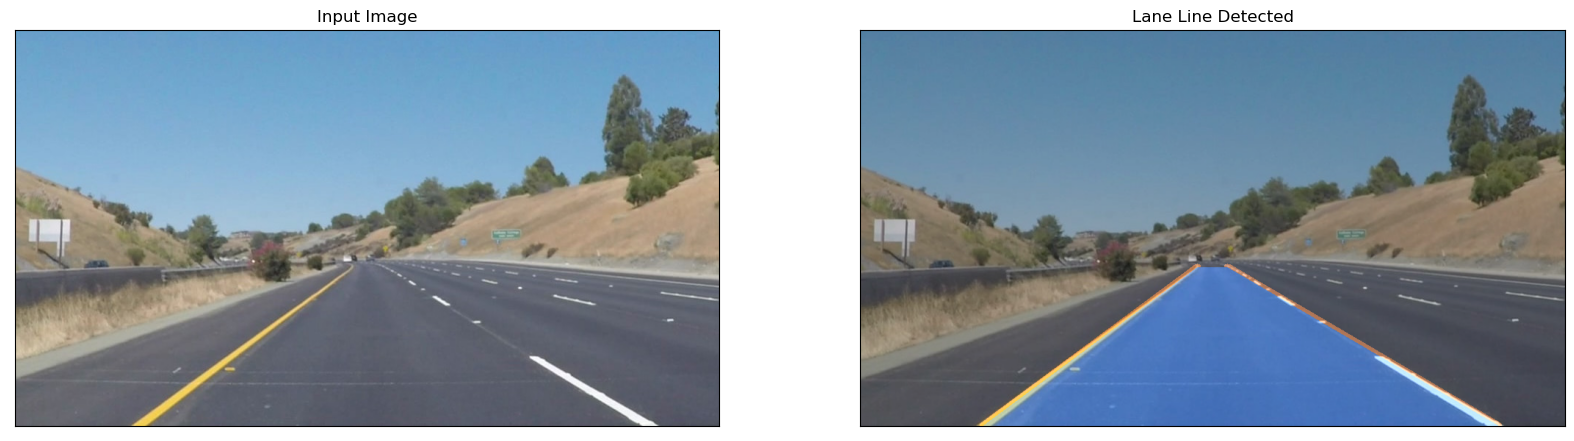

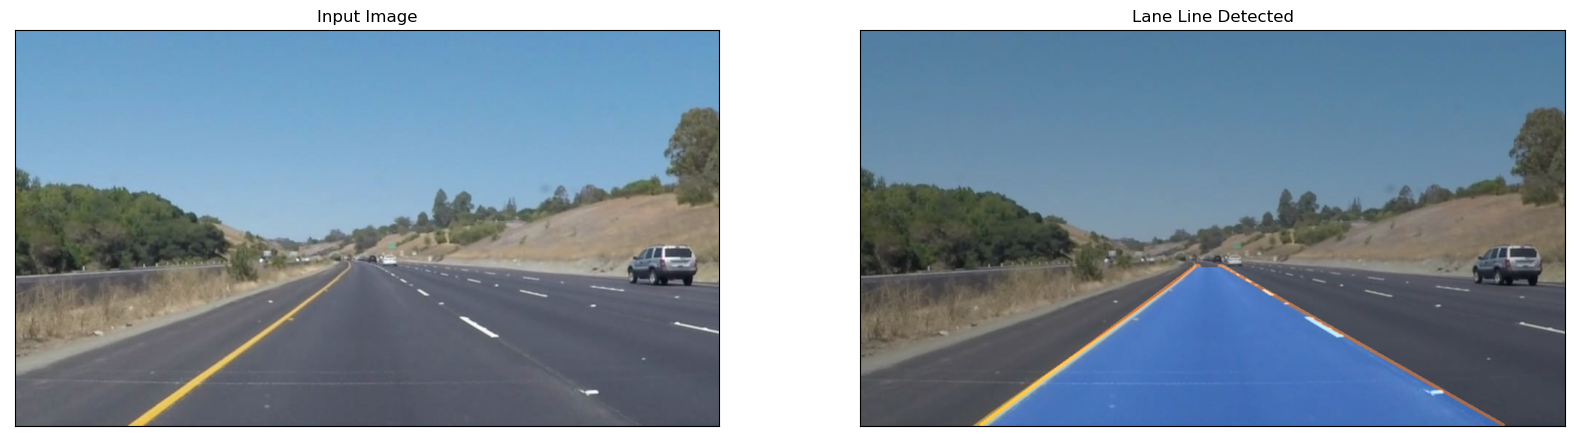

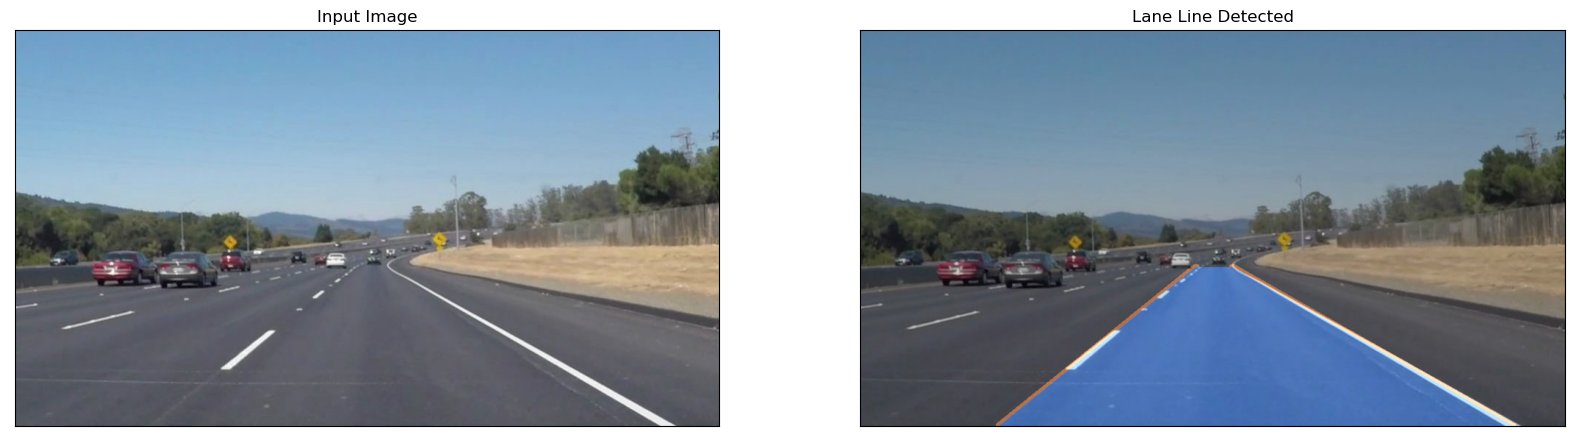

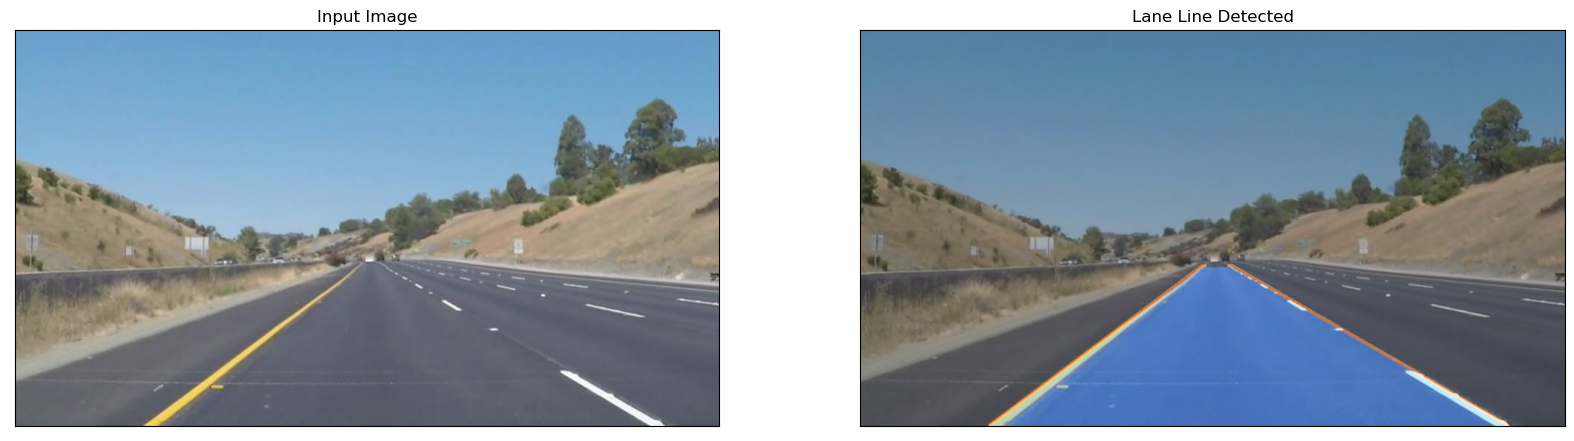

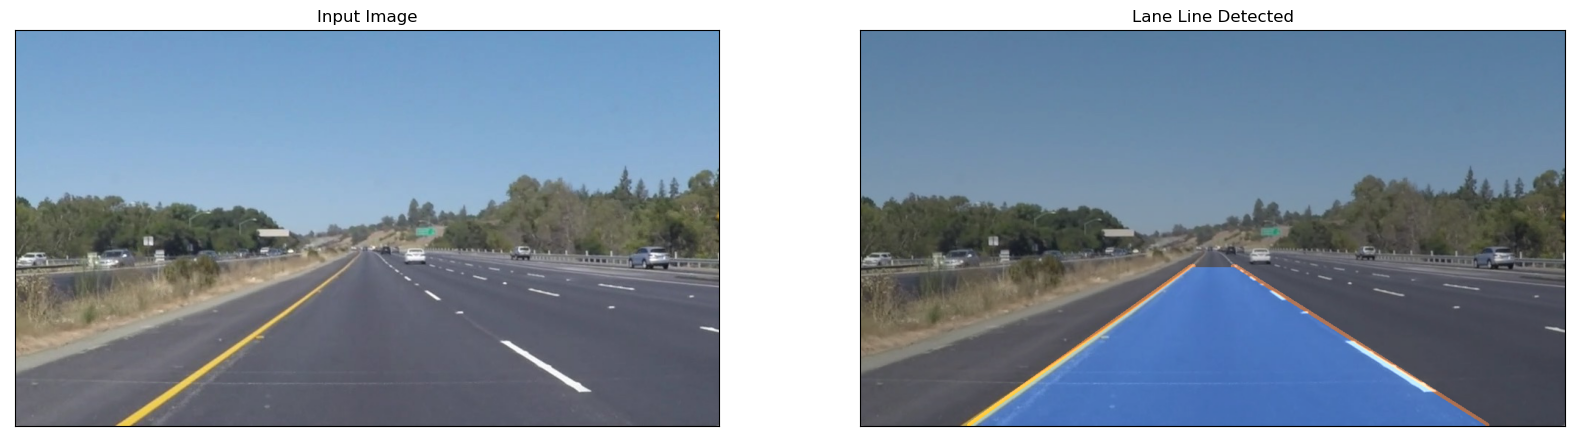

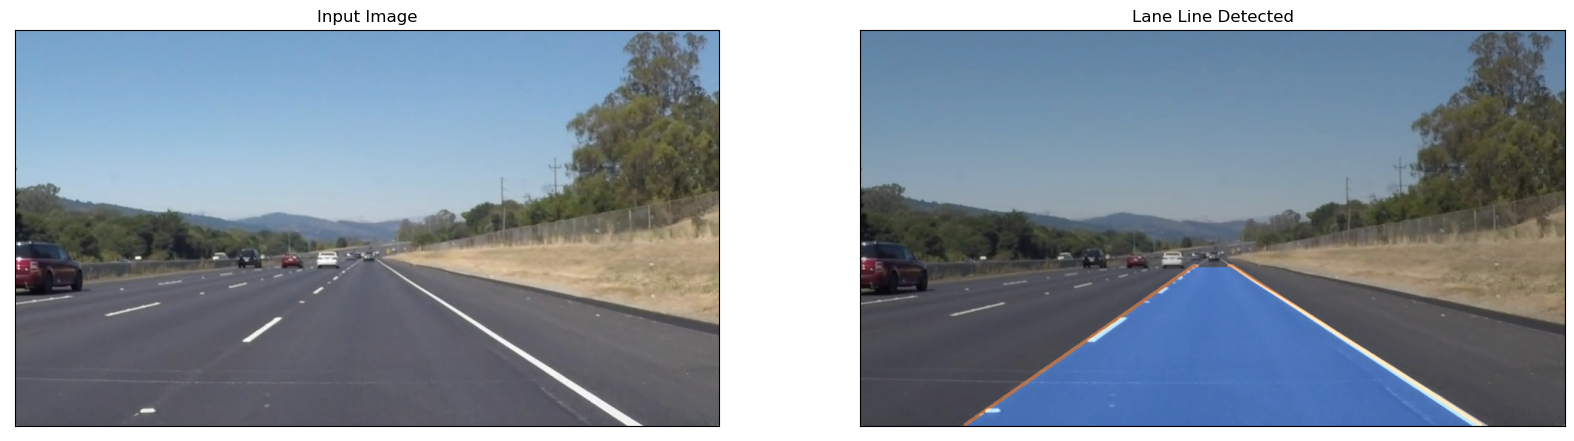

In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

for image_path in list(os.listdir('./test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_pipeline(image))
    ax.set_title("Lane Line Detected")
    plt.show()


In [9]:
cap = cv2.VideoCapture("test_videos/solidYellowLeft.mp4")
output_frame=[]
frame_width=cap.get(cv2.CAP_PROP_FRAME_WIDTH)
frame_height=cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
_, frame = cap.read()

while (cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        output=lane_pipeline(frame)
        output_frame.append(output)
        
    else:
        break
    
    if cv2.waitKey(1) == ord("q"):
        break

cap.release()
output_path = "solidYellowLeft_output.avi" # converting it to avi because XVID codec supports avi format better than mp4
fourcc = cv2.VideoWriter_fourcc(*"XVID") 
size=(int(frame_width),int(frame_height))
out = cv2.VideoWriter(output_path, fourcc, 30, size) # 30 is FPS - Hyperparameter

for frame in output_frame:
    out.write(frame)

out.release()

cv2.destroyAllWindows()